In [1]:
import numpy as np
%load_ext autoreload
%autoreload 2
from CalRun import CalRun, CalPredictor, shift_vec
from tqdm.notebook import tqdm
import matplotlib

In [100]:
heal = []
trueb = []
dlist = []
d=-0.7

np.random.seed(131)
tcal_table = np.random.uniform(0,16000,(10,4)).astype(int)
drift_table = np.random.uniform(-1,1 ,(10,4))
seed_table = np.random.uniform(0,100000 ,(10,4)).astype(int)
pixlist = ['91_t','4_t','180_p','200_p']
for tcal_line, drift_line,seed_line in tqdm(list(zip(tcal_table, drift_table,seed_table))):    
    heal.append([])    
    for pixd,dr,sh,seed in zip(pixlist,drift_line, tcal_line,seed_line):
        print (dr,sh,seed,' <-')
        C=CalRun (N=120, pf=True, sky=True, cal=True, notch=True, verbose=False, drift=dr, A=1.0, 
                     calfile = f"data/healpix_calib/calib_hp{pixd}", cal_shift = sh,seed=seed)
        C.get_cal()
        heal[-1].append(C)


for pixd in pixlist:
        trueb.append(np.load(f"data/healpix_calib/calib_hp{pixd}.beam.npy"))

  0%|          | 0/10 [00:00<?, ?it/s]

-0.15191310888833587 10402 74346  <-
cache/ed475cb2ee047150d420e80127df6bcc.pickle
-0.6762543114521768 15169 24777  <-
cache/119cdbd86048930e04c284526fd415a6.pickle
0.0406883500463775 6208 49229  <-
cache/6a9975adda6751bf1330aaaf799b1205.pickle
0.2140825954847978 10260 42474  <-
cache/af2e8f2f5c62c1fb5063f3c7cfc8e96d.pickle
0.161611402967893 11048 29006  <-
cache/d9d9b8e04a49ffb8f4ad9a556816be74.pickle
0.6422319367067575 2025 98668  <-
cache/56bb580a224d772a94fdf9c5bd6b61bf.pickle
0.9699837677431526 3831 33945  <-
cache/742265e514b66803f4735c04b8793dea.pickle
0.8689898407520613 4066 19970  <-
cache/a3b535ccf6636cc92b5ae3766e88acff.pickle
0.8061097295492319 6823 82869  <-
cache/c93f4bd8fc71def7a6dca86344ab7ab1.pickle
-0.32394759421082564 13424 36263  <-
cache/ee8504bf48e240e456b9bccf4707837a.pickle
0.5664885713886341 11920 71002  <-
cache/e9b806b3ef64938b20023e5dc061a544.pickle
0.4874694889500901 6090 40303  <-
cache/4e34dcf018df99549760c8e87c36f343.pickle
0.16117092449669146 4187 38854

In [101]:
hsrcal = "data/healpix_calib/calib_hp89_p"
def fitanal(heal_line, drifts, tcals):
    result = []
    if drifts is None:
        drifts = [h.drift_ppm for h in heal_line]
    if tcals is None:
        tcals = [0]*len(heal_line)
    for no,d, calshift in zip(heal_line,drifts, tcals):
        seenbefore = []
        while True:
            print ("trying calshift = ",calshift, "drift=",d)
            no.get_sig2(calshift,d,hsrcal)
            calshift = (calshift+no.cal_shift)%(2048*16)
            if (no.cal_shift==0) or (calshift in seenbefore) or (len(seenbefore)>10):
                break
            seenbefore.append(calshift)
        result.append((no.A,no.rbeam))
    return result

pixlist = ['91_t','4_t','180_p','200_p']

res_fd = []
res_td = []
for tcal_line, drift_line,seed_line, heal_line in zip(tcal_table, drift_table, seed_table,heal):
    res_fd.append(fitanal(heal_line, None, tcal_line))
    res_td.append(fitanal(heal_line, drift_line, tcal_line))



trying calshift =  10402 drift= -0.010189508555926544
max cor: 4923.409299397967
trying calshift =  10474 drift= -0.010189508555926544
max cor: 4899.52642911243
trying calshift =  10471 drift= -0.010189508555926544
max cor: 4870.234650958975
trying calshift =  10470 drift= -0.010189508555926544
max cor: 5317.182151999646
trying calshift =  15169 drift= -0.6765833681135226
max cor: 632.0969685122009
trying calshift =  15168 drift= -0.6765833681135226
max cor: 627.1693734372238
trying calshift =  6208 drift= 0.04075803422370618
max cor: 1138.630582455216
trying calshift =  10260 drift= 0.17118374373956594
max cor: 268.88756649031507
trying calshift =  26402 drift= 0.17118374373956594
max cor: 711.3437063711326
trying calshift =  10272 drift= 0.17118374373956594
max cor: 346.02556556416636
trying calshift =  26672 drift= 0.17118374373956594
max cor: 426.19143702841905
trying calshift =  10050 drift= 0.17118374373956594
max cor: 486.26993923617425
trying calshift =  10051 drift= 0.17118374

In [102]:
tcal_table[0][0],drift_table[0][0],heal[0][0].drift_ppm

(10402, -0.15191310888833587, -0.010189508555926544)

/tmp/ipykernel_3593/2829552060.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res)


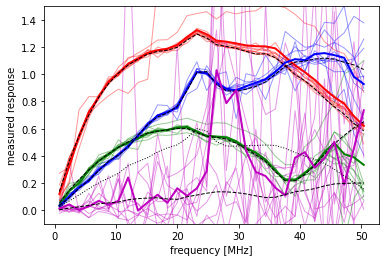

In [107]:
def avg(v):
    return v.reshape((-1,16)).mean(axis=1)
cmap = matplotlib.cm.get_cmap('plasma')
hsrbeam = np.load(hsrcal+'.beam.npy')

cf=heal[0][0].cf
use='fitted'

res = res_td if use=='true' else res_fd
res = np.array(res)

clrmap='rgbm'
for line in res:
    for cc,((A,rbeam),tb) in enumerate(zip(line,trueb)):
        clr = clrmap[cc]

        plt.plot(avg(cf),avg(np.real(rbeam*hsrbeam)),lw=1, alpha=0.4, color=clr)
        

line=res.mean(axis=0)
line1=res[1:,:].mean(axis=0)
line[0]=line1[0]
for cc,((A,rbeam),tb) in enumerate(zip(line,trueb)):
    clr = clrmap[cc]
    plt.plot(avg(cf),avg(np.real(rbeam*hsrbeam)),lw=2, color=clr)
    plt.plot(avg(cf),avg(tb),lw=1, color='k', ls='--')
        
        
plt.plot(avg(cf),avg(hsrbeam),lw=1, color='k', ls=':')
plt.xlabel('frequency [MHz]')
plt.ylabel('measured response')
plt.ylim(-0.1,1.5)
plt.savefig(f'heal_response_{use}.pdf')           
                  
    #plt.plot(avg(no.cf),avg(np.imag(no.rbeam)/no.A),lw=2, color=clr)#-0.1*cc)
#plt.semilogy()


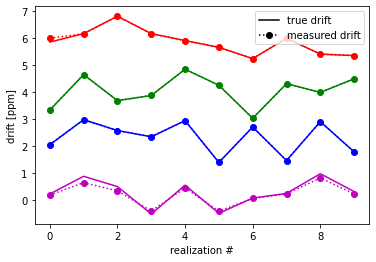

In [87]:
for i in range(4):
    plt.plot(drift_table[:,3-i]+2*i,'-',color=clrmap[3-i])
    plt.plot(np.array([h[3-i].drift_ppm for h in heal])+2*i,'o:',color=clrmap[3-i])
plt.plot([],[],'k-', label='true drift')
plt.plot([],[],'ko:', label='measured drift')
plt.xlabel('realization #')
plt.ylabel('drift [ppm]')
plt.legend(loc='upper right')
plt.savefig('heal-drift-rec.pdf')

In [214]:
        def add4 (ls,i):
            s = ls[-1]
            if i==4:
                ls+=[s+0,s+1,s+2,s+3,s+4]
            elif i==3:
                ls+=[s+0,s+1,s+2,s+2,s+3]
            elif i==2:
                ls+=[s+0,s+1,s+1,s+2,s+2]
            elif i==1:
                ls+=[s+0,s+0,s+0,s+1,s+1]
            elif i==0:
                ls+=[s+0,s+0,s+0,s+0,s+0]
            elif i==-1:
                ls+=[s+0,s-0,s-0,s-1,s-1]
            elif i==-2:
                ls+=[s+0,s-1,s-1,s-2,s-2]
            elif i==-3:
                ls+=[s+0,s-1,s-2,s-2,s-3]
            elif i==-4:
                ls+=[s+0,s-1,s-2,s-3,s-4]
                


In [217]:
a=[0]
add4(a,2)
print(a)

[0, 0, 1, 1, 2, 2]


In [24]:
a=np.linspace(0,10,4)

In [27]:
a[np.array([1,0,2,3,2])]

array([ 3.33333333,  0.        ,  6.66666667, 10.        ,  6.66666667])

In [202]:
f=open('ladder.txt','w')
for i in range(2048*8):
    v=1 if (i==1000) else 0   
    f.write(f'{v}\n')
for i in range(2048*8):
    v=1 if (i==1000) else 0   
    f.write(f'{-v}\n')
f.close()
